## 모듈 임포트

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

## 데이터 로드

In [2]:
!wget 'https://bit.ly/3dD5MU9'

import zipfile
with zipfile.ZipFile('3dD5MU9', 'r') as existing_zip:
    existing_zip.extractall('data')

--2021-06-07 13:00:58--  https://bit.ly/3dD5MU9
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z [following]
--2021-06-07 13:00:58--  https://drive.google.com/uc?export=download&id=1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z
Resolving drive.google.com (drive.google.com)... 64.233.189.102, 64.233.189.138, 64.233.189.113, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rk94q7td6b1cp4bcng3385nl2ejtd50l/1623070800000/00192245294648390361/*/1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z?e=download [following]
--2021-06-07 13:01:05--  https://doc-14-94-docs.googleusercontent.com/docs/securesc/

In [3]:
energy = pd.read_csv('data/energy.csv')
dangjin_fcst = pd.read_csv('./data/dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('./data/ulsan_fcst_data.csv')

## 데이터 병합 
- 가장 나중의 예측 데이터가 가장 좋다고 가정.

In [4]:
def to_date(x):
    return timedelta(hours=x)

In [5]:
def generate_df(df_):
    df = df_.copy()

    df['Forecast_time'] = pd.to_datetime(df['Forecast time'])

    # 20 시
    a = df[df["forecast"] == 4.0]
    a = a[a["Forecast time"].apply(lambda x: "20:00:00" in x)]
    a.loc[:, 'Forecast_time'] = a.loc[:, 'Forecast_time'] + a.loc[:, 'forecast'].map(to_date)

    # 23 시
    b = df[df["forecast"] <= 22]
    b = b[b["Forecast time"].apply(lambda x: "23:00:00" in x)]
    b.loc[:, 'Forecast_time'] = b.loc[:, 'Forecast_time'] + b.loc[:, 'forecast'].map(to_date)

    # 병합
    c = pd.concat([a, b])
    print(f"20시 사용 데이터 길이 : {len(a)}")
    print(f"23시 사용 데이터 길이 : {len(b)}")
    print(f"합친 데이터 길이 : {len(c)}")
    print()

    # 정렬
    c.sort_values(by=['Forecast_time'], inplace=True)
    c = c[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

    return c

In [6]:
dangjin_filled = generate_df(dangjin_fcst)
ulsan_filled = generate_df(ulsan_fcst)

20시 사용 데이터 길이 : 1096
23시 사용 데이터 길이 : 7672
합친 데이터 길이 : 8768

20시 사용 데이터 길이 : 1096
23시 사용 데이터 길이 : 7672
합친 데이터 길이 : 8768



## 보간

In [7]:
def interpolate_df(df, method='linear'):
    new_df = pd.DataFrame()
    new_df['Forecast_time'] = pd.date_range(start=df['Forecast_time'].iloc[0], end=df['Forecast_time'].iloc[-1], freq='H')
    new_df = pd.merge(new_df, df, on='Forecast_time', how='outer')
    return new_df.interpolate(method=method)

In [8]:
dangjin_interpolated = interpolate_df(dangjin_filled, method='linear')
ulsan_interpolated = interpolate_df(ulsan_filled, method='linear')

## 피처엔지니어링

In [9]:
!pip install Catboost

     |████████████████████████████████| 69.2MB 42kB/s 


In [10]:
from catboost import CatBoostRegressor

## 학습 데이터 전처리

In [11]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*90]
    val_df = feature_df.iloc[-24*90:]
    
    # 발전량이 0인 데이터를 제외
    #train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

## LGBM custom metric

In [13]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

## Validation Metric

In [ ]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

## bayesian optimization 
---
- bayesian optimization 를 이용하여 하이퍼 파라미터 튜닝
- lgbm만 적용.

In [12]:
# bayesian optimization 패키지 설치
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11686 sha256=04502a0c57d5e9fa1de9dfcb44241bd0aceef1a45256e0266a7979db97ad5c61
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [14]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

## LightGBM Hyperparameter

AttributeError: ignored

In [ ]:

params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'MultiRMSE',
    'seed':42
}

In [16]:
dangjin_interpolated['Forecast_time'] = dangjin_interpolated['Forecast_time'].astype('str')
ulsan_interpolated['Forecast_time'] = ulsan_interpolated['Forecast_time'].astype('str')

## 당진 수상태양광 예측 모델 학습

In [17]:
energy = energy.fillna(0)

In [ ]:
bayesian_params = {
    'max_depth': (5, 20), 
    'num_leaves': (24, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

def lgb_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":1000, "learning_rate":0.01,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0),
        "metric" : 'rmse'
    }
    cv_result = lgb.cv(params, train_data, nfold=5, seed=0, verbose_eval =200,stratified=False)
    return (-1.0 * np.array(cv_result['rmse-mean'])).max()

train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_floating')
train_data = lgb.Dataset(train_x, train_y)
lgbBO = BayesianOptimization(lgb_eval, bayesian_params, random_state=42)


lgbBO.maximize(init_points=5, n_iter=25)
####################################################
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

#################################################################
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_floating')
cat1 = CatBoostRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE')
cat1.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

0:	learn: 194.1556369	test: 194.1556369	test1: 155.6591443	best: 155.6591443 (0)	total: 56.1ms	remaining: 4m 40s
100:	learn: 137.5433396	test: 137.5433396	test1: 109.8819339	best: 109.8819339 (100)	total: 849ms	remaining: 41.2s
200:	learn: 105.8964096	test: 105.8964096	test1: 86.3193966	best: 86.3193966 (200)	total: 1.65s	remaining: 39.5s
300:	learn: 89.0977659	test: 89.0977659	test1: 74.9898487	best: 74.9898487 (300)	total: 2.43s	remaining: 38s
400:	learn: 80.2636787	test: 80.2636787	test1: 69.4558333	best: 69.4558333 (400)	total: 3.21s	remaining: 36.8s
500:	learn: 75.3991933	test: 75.3991933	test1: 66.4545530	best: 66.4545530 (500)	total: 3.96s	remaining: 35.5s
600:	learn: 72.5018985	test: 72.5018985	test1: 65.1256411	best: 65.1256411 (600)	total: 4.71s	remaining: 34.5s
700:	learn: 70.6055045	test: 70.6055045	test1: 64.3920071	best: 64.3920071 (700)	total: 5.47s	remaining: 33.6s
800:	learn: 69.2313444	test: 69.2313444	test1: 63.9694251	best: 63.9694251 (800)	total: 6.26s	remaining: 3

In [ ]:
'colsample_bytree': 0.7840043724584478, 'max_bin': 109.42082906265013, 'max_depth': 11.939485103471496, 'min_child_samples': 47.27436173622021, 'min_child_weight': 44.12615815161272, 'num_leaves': 61.168181706089655, 'reg_alpha': 7.967786769707356, 'reg_lambda': 1.4818125424587414, 'subsample': 0.835744966051806}

In [26]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_floating')
dangjin_floating_model = LGBMRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,loss_function='MultiRMSE',
                                       colsample_bytree =  0.7840043724584478,max_bin = 109, max_depth = 12, min_child_samples = 47, min_child_weight = 44, num_leaves = 61, reg_alpha=8, reg_lambda= 1.5, subsample=  0.835744966051806)
dangjin_floating_model.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 18665.5	valid_1's l2: 12819.9
[200]	training's l2: 10718.4	valid_1's l2: 8168.04
[300]	training's l2: 6993.68	valid_1's l2: 5981.95
[400]	training's l2: 5247.29	valid_1's l2: 5012.31
[500]	training's l2: 4372.12	valid_1's l2: 4566.6
[600]	training's l2: 3875.47	valid_1's l2: 4373.11
[700]	training's l2: 3545.28	valid_1's l2: 4275.84
[800]	training's l2: 3293.94	valid_1's l2: 4231.69
[900]	training's l2: 3097.22	valid_1's l2: 4205.1
[1000]	training's l2: 2943.1	valid_1's l2: 4195.49
[1100]	training's l2: 2818.51	valid_1's l2: 4192.8
Early stopping, best iteration is:
[1068]	training's l2: 2855.53	valid_1's l2: 4189.82


LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.7840043724584478, importance_type='split',
              learning_rate=0.005, loss_function='MultiRMSE', max_bin=109,
              max_depth=12, min_child_samples=47, min_child_weight=44,
              min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=61,
              objective=None, random_seed=42, random_state=None, reg_alpha=8,
              reg_lambda=1.5, silent=True, subsample=0.835744966051806,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_floating')
dangjin_floating_model = LGBMRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE',
                                       colsample_bytree =  1,max_depth = 17, min_child_samples = 17, min_child_weight = 14, num_leaves = 63, reg_alpha=49.75855787791481, reg_lambda= 0.026935271560602856, subsample= 1.0)
dangjin_floating_model.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 17468.2	valid_1's l2: 12314.7
[200]	training's l2: 9505.46	valid_1's l2: 7518.53
[300]	training's l2: 6160.28	valid_1's l2: 5552.15
[400]	training's l2: 4621.98	valid_1's l2: 4734.6
[500]	training's l2: 3850.62	valid_1's l2: 4397.85
[600]	training's l2: 3360.87	valid_1's l2: 4265.15
[700]	training's l2: 3025.62	valid_1's l2: 4199.41
[800]	training's l2: 2769.75	valid_1's l2: 4179.53
[900]	training's l2: 2594.36	valid_1's l2: 4162.22
[1000]	training's l2: 2454.82	valid_1's l2: 4151.01
[1100]	training's l2: 2326.93	valid_1's l2: 4141.93
[1200]	training's l2: 2230.02	valid_1's l2: 4123.69
[1300]	training's l2: 2152.63	valid_1's l2: 4103.76
[1400]	training's l2: 2065.5	valid_1's l2: 4105.27
Early stopping, best iteration is:
[1309]	training's l2: 2144.3	valid_1's l2: 4102.56


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              depth=8, importance_type='split', learning_rate=0.005,
              loss_function='MultiRMSE', max_depth=17, min_child_samples=17,
              min_child_weight=14, min_split_gain=0.0, n_estimators=5000,
              n_jobs=-1, num_leaves=63, objective=None, random_seed=42,
              random_state=None, reg_alpha=49.75855787791481,
              reg_lambda=0.026935271560602856, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's score: 10.8133
[200]	valid_0's score: 8.3101
[300]	valid_0's score: 7.81402
[400]	valid_0's score: 7.79694
Early stopping, best iteration is:
[346]	valid_0's score: 7.7516


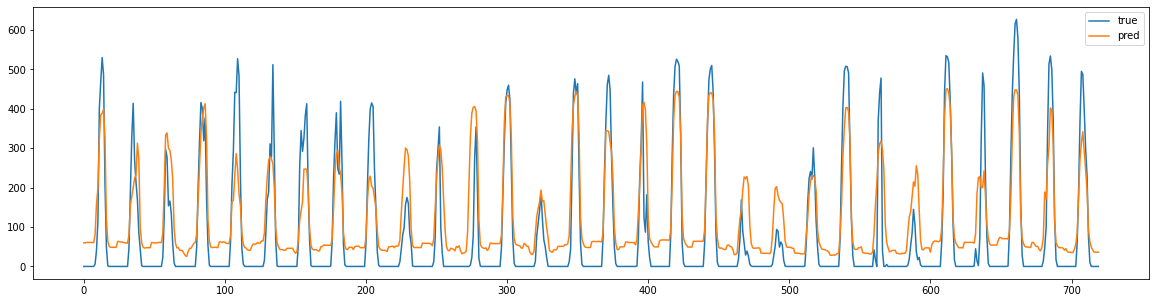

CV Score :  8.523591303464043


In [ ]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

## 당진 자재 창고 태양광 예측 모델 학습

In [ ]:
bayesian_params = {
    'max_depth': (5, 20), 
    'num_leaves': (24, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

def lgb_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":1000, "learning_rate":0.01,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0),
        "metric" : 'rmse'
    }
    cv_result = lgb.cv(params, train_data, nfold=5, seed=0, verbose_eval =200,stratified=False)
    return (-1.0 * np.array(cv_result['rmse-mean'])).max()

train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_warehouse')
train_data = lgb.Dataset(train_x, train_y)
lgbBO = BayesianOptimization(lgb_eval, bayesian_params, random_state=42)




lgbBO.maximize(init_points=5, n_iter=25)
####################################################
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

#################################################################
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_warehouse')
cat2 = CatBoostRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE')
cat2.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

0:	learn: 147.2824497	test: 147.2824497	test1: 127.8765996	best: 127.8765996 (0)	total: 8.75ms	remaining: 43.7s
100:	learn: 104.4879035	test: 104.4879035	test1: 91.1236448	best: 91.1236448 (100)	total: 809ms	remaining: 39.3s
200:	learn: 80.7833174	test: 80.7833174	test1: 72.2627678	best: 72.2627678 (200)	total: 1.61s	remaining: 38.4s
300:	learn: 68.1673314	test: 68.1673314	test1: 62.7982141	best: 62.7982141 (300)	total: 2.38s	remaining: 37.2s
400:	learn: 61.5583586	test: 61.5583586	test1: 58.6091217	best: 58.6091217 (400)	total: 3.19s	remaining: 36.6s
500:	learn: 57.9040254	test: 57.9040254	test1: 56.5747823	best: 56.5747823 (500)	total: 4s	remaining: 35.9s
600:	learn: 55.7329807	test: 55.7329807	test1: 55.5735458	best: 55.5735458 (600)	total: 4.77s	remaining: 34.9s
700:	learn: 54.1945790	test: 54.1945790	test1: 55.0722148	best: 55.0722148 (700)	total: 5.56s	remaining: 34.1s
800:	learn: 53.0015268	test: 53.0015268	test1: 54.7930339	best: 54.7930339 (800)	total: 6.3s	remaining: 33.1s
90

In [ ]:
{'colsample_bytree': 0.7840043724584478, 'max_bin': 109.42082906265013, 'max_depth': 11.939485103471496, 'min_child_samples': 47.27436173622021, 'min_child_weight': 44.12615815161272, 'num_leaves': 61.168181706089655, 'reg_alpha': 7.967786769707356, 'reg_lambda': 1.4818125424587414, 'subsample': 0.835744966051806}}

In [37]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_warehouse')
dangjin_warehouse_model = LGBMRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE',
                                       colsample_bytree =  1,max_depth = 17, min_child_samples = 17, min_child_weight = 14, num_leaves = 63, reg_alpha=49.75855787791481, reg_lambda= 0.026935271560602856, subsample= 1.0)
dangjin_warehouse_model.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 10057.3	valid_1's l2: 8089.53
[200]	training's l2: 5471.98	valid_1's l2: 4970.63
[300]	training's l2: 3539.38	valid_1's l2: 3813.67
[400]	training's l2: 2674.14	valid_1's l2: 3368.68
[500]	training's l2: 2229.72	valid_1's l2: 3195.32
[600]	training's l2: 1963	valid_1's l2: 3129.7
[700]	training's l2: 1785.8	valid_1's l2: 3105.45
[800]	training's l2: 1651.59	valid_1's l2: 3057.7
[900]	training's l2: 1547.15	valid_1's l2: 3032.77
[1000]	training's l2: 1460.65	valid_1's l2: 3021.56
[1100]	training's l2: 1380.61	valid_1's l2: 3024.25
Early stopping, best iteration is:
[1051]	training's l2: 1417.22	valid_1's l2: 3020.03


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              depth=8, importance_type='split', learning_rate=0.005,
              loss_function='MultiRMSE', max_depth=17, min_child_samples=17,
              min_child_weight=14, min_split_gain=0.0, n_estimators=5000,
              n_jobs=-1, num_leaves=63, objective=None, random_seed=42,
              random_state=None, reg_alpha=49.75855787791481,
              reg_lambda=0.026935271560602856, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [31]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_warehouse')
dangjin_warehouse_model = LGBMRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE',
                                       colsample_bytree =  0.8803371255183132,max_bin= 366,num_leaves = 41,
                                        max_depth = 14, min_child_samples = 24, min_child_weight = 15, reg_alpha=1.18, reg_lambda= 9.67, subsample= 0.6)
dangjin_warehouse_model.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 11057.3	valid_1's l2: 8775.31
[200]	training's l2: 6541.61	valid_1's l2: 5624
[300]	training's l2: 4394.57	valid_1's l2: 4180.1
[400]	training's l2: 3371.53	valid_1's l2: 3561.22
[500]	training's l2: 2838.92	valid_1's l2: 3287.73
[600]	training's l2: 2526.08	valid_1's l2: 3170.87
[700]	training's l2: 2319	valid_1's l2: 3112.92
[800]	training's l2: 2161.18	valid_1's l2: 3067.99
[900]	training's l2: 2050.73	valid_1's l2: 3058.15
[1000]	training's l2: 1958.14	valid_1's l2: 3053.94
Early stopping, best iteration is:
[967]	training's l2: 1988.39	valid_1's l2: 3052.44


LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8803371255183132, depth=8,
              importance_type='split', learning_rate=0.005,
              loss_function='MultiRMSE', max_bin=366, max_depth=14,
              min_child_samples=24, min_child_weight=15, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=41, objective=None,
              random_seed=42, random_state=None, reg_alpha=1.18,
              reg_lambda=9.67, silent=True, subsample=0.6,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's score: 9.31878
[200]	valid_0's score: 7.03711
[300]	valid_0's score: 6.55175
[400]	valid_0's score: 6.55575
Early stopping, best iteration is:
[305]	valid_0's score: 6.53888


## 당진 태양광 예측 모델 학습

In [ ]:
bayesian_params = {
    'max_depth': (5, 20), 
    'num_leaves': (24, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

def lgb_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":1000, "learning_rate":0.01,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0),
        "metric" : 'rmse'
    }
    cv_result = lgb.cv(params, train_data, nfold=5, seed=0, verbose_eval =200,stratified=False)
    return (-1.0 * np.array(cv_result['rmse-mean'])).max()

train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin')
train_data = lgb.Dataset(train_x, train_y)
lgbBO = BayesianOptimization(lgb_eval, bayesian_params, random_state=42)



lgbBO.maximize(init_points=5, n_iter=25)
####################################################
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

#################################################################
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin')
cat3 = CatBoostRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE')
cat3.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

0:	learn: 221.6732494	test: 221.6732494	test1: 195.7935698	best: 195.7935698 (0)	total: 8.94ms	remaining: 44.7s
100:	learn: 155.4908448	test: 155.4908448	test1: 139.4988065	best: 139.4988065 (100)	total: 828ms	remaining: 40.2s
200:	learn: 118.4531298	test: 118.4531298	test1: 110.9761129	best: 110.9761129 (200)	total: 1.63s	remaining: 38.8s
300:	learn: 98.6978945	test: 98.6978945	test1: 96.8762299	best: 96.8762299 (300)	total: 2.4s	remaining: 37.5s
400:	learn: 88.3719796	test: 88.3719796	test1: 90.2104106	best: 90.2104106 (400)	total: 3.2s	remaining: 36.7s
500:	learn: 82.8786453	test: 82.8786453	test1: 86.9354674	best: 86.9354674 (500)	total: 3.97s	remaining: 35.7s
600:	learn: 79.7389644	test: 79.7389644	test1: 85.2253733	best: 85.2253733 (600)	total: 4.75s	remaining: 34.8s
700:	learn: 77.7820001	test: 77.7820001	test1: 84.2707720	best: 84.2707720 (700)	total: 5.55s	remaining: 34s
800:	learn: 76.4198706	test: 76.4198706	test1: 83.7245505	best: 83.7215136 (799)	total: 6.34s	remaining: 33

In [ ]:
{'target': -67.37835160276464, 'params': {'colsample_bytree': 0.8803371255183132, 'max_bin': 366.3312849753787, 'max_depth': 14.426679148899519, 'min_child_samples': 24.334988996735756, 'min_child_weight': 14.85309783894488, 'num_leaves': 41.115245176939176, 'reg_alpha': 1.1811080746620453, 'reg_lambda': 9.672295351116277, 'subsample': 0.6051769440265253}}

In [33]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin')
dangjin_model = LGBMRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE',
                                       colsample_bytree =  0.7840043724584478,max_bin= 109,num_leaves = 61,
                                        max_depth = 12, min_child_samples = 47, min_child_weight = 44, reg_alpha=7.96, reg_lambda= 1.48, subsample= 0.835744966051806)
dangjin_model.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 23972.9	valid_1's l2: 20038.7
[200]	training's l2: 13505.7	valid_1's l2: 12722.1
[300]	training's l2: 8680.92	valid_1's l2: 9453.09
[400]	training's l2: 6494.53	valid_1's l2: 8076.26
[500]	training's l2: 5396.67	valid_1's l2: 7532.7
[600]	training's l2: 4788.04	valid_1's l2: 7312.69
[700]	training's l2: 4394.52	valid_1's l2: 7184.58
[800]	training's l2: 4115.53	valid_1's l2: 7123.25
[900]	training's l2: 3903.11	valid_1's l2: 7085.49
[1000]	training's l2: 3718.13	valid_1's l2: 7095.42
Early stopping, best iteration is:
[912]	training's l2: 3878.86	valid_1's l2: 7080.32


LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.7840043724584478, depth=8,
              importance_type='split', learning_rate=0.005,
              loss_function='MultiRMSE', max_bin=109, max_depth=12,
              min_child_samples=47, min_child_weight=44, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=61, objective=None,
              random_seed=42, random_state=None, reg_alpha=7.96,
              reg_lambda=1.48, silent=True, subsample=0.835744966051806,
              subsample_for_bin=200000, subsample_freq=0)

In [38]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin')
dangjin_model = LGBMRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE',
                                       colsample_bytree =  1,max_depth = 17, min_child_samples = 17, min_child_weight = 14, num_leaves = 63, reg_alpha=49.75855787791481, reg_lambda= 0.026935271560602856, subsample= 1.0)
dangjin_model.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 22350.1	valid_1's l2: 18657.5
[200]	training's l2: 11932.6	valid_1's l2: 11507.9
[300]	training's l2: 7681.95	valid_1's l2: 8825.45
[400]	training's l2: 5773.28	valid_1's l2: 7726.75
[500]	training's l2: 4795	valid_1's l2: 7345.13
[600]	training's l2: 4210.44	valid_1's l2: 7175.93
[700]	training's l2: 3817.49	valid_1's l2: 7071.54
[800]	training's l2: 3499.76	valid_1's l2: 7084.52
Early stopping, best iteration is:
[709]	training's l2: 3788.45	valid_1's l2: 7070.29


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              depth=8, importance_type='split', learning_rate=0.005,
              loss_function='MultiRMSE', max_depth=17, min_child_samples=17,
              min_child_weight=14, min_split_gain=0.0, n_estimators=5000,
              n_jobs=-1, num_leaves=63, objective=None, random_seed=42,
              random_state=None, reg_alpha=49.75855787791481,
              reg_lambda=0.026935271560602856, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's score: 13.5793
[200]	valid_0's score: 10.8284
[300]	valid_0's score: 10.3869
[400]	valid_0's score: 10.3118
Early stopping, best iteration is:
[389]	valid_0's score: 10.3057


## 울산 태양광 예측 모델 학습

In [34]:
bayesian_params = {
    'max_depth': (5, 20), 
    'num_leaves': (24, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

def lgb_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":1000, "learning_rate":0.01,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0),
        "metric" : 'rmse'
    }
    cv_result = lgb.cv(params, train_data, nfold=5, seed=0, verbose_eval =200,stratified=False)
    return (-1.0 * np.array(cv_result['rmse-mean'])).max()

train_x, train_y, val_x, val_y = train_datast(energy, ulsan_interpolated, target='ulsan')
train_data = lgb.Dataset(train_x, train_y)

lgbB1 = BayesianOptimization(lgb_eval, bayesian_params, random_state=42)


lgbB1.maximize(init_points=5, n_iter=25)
####################################################
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbB1.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

#################################################################
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbB1.res[np.argmax(np.array(target_list))]
print(max_dict)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 43.3444 + 0.790529
[400]	cv_agg's rmse: 35.2592 + 0.819072
[600]	cv_agg's rmse: 33.3081 + 0.849848
[800]	cv_agg's rmse: 32.4558 + 0.860089
[1000]	cv_agg's rmse: 31.8717 + 0.867923
|  1        | -31.87    |  0.6873   |  475.9    |  15.98    |  123.7    |  8.645    |  30.24    |  2.914    |  8.662    |  0.8006   |
[200]	cv_agg's rmse: 41.1347 + 0.769208
[400]	cv_agg's rmse: 34.567 + 0.858233
[600]	cv_agg's rmse: 33.1384 + 0.902847
[800]	cv_agg's rmse: 32.3811 + 0.890606
[1000]	cv_agg's rmse: 31.8738 + 0.879971
|  2        | -31.87    |  0.854    |  20.09    |  19.55    |  168.2    |  11.4     |  31.27    |  9.178    |  3.043    |  0.7624   |
[200]	cv_agg's rmse: 42.5475 + 0.792917
[400]	cv_agg's rmse: 34.0367 + 0.788636
[600]	cv_agg's rmse: 31.8651 + 0.785575
[800]	cv_agg's rmse: 30.9206 + 0.782764
[1000]	cv_agg's rmse: 30.278 + 0.772476
|  3        | -30.28    |  0.716    |  152.7    |  14.18    |  36.5     |  15.32    |  38.65    |  22.81    |  7.852    |  0.5998  

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 51.0745 + 0.670056
[400]	cv_agg's rmse: 37.9878 + 0.679691
[600]	cv_agg's rmse: 34.6002 + 0.72674
[800]	cv_agg's rmse: 33.0454 + 0.749894
[1000]	cv_agg's rmse: 32.0628 + 0.77945
|  6        | -32.06    |  0.5191   |  148.5    |  13.23    |  45.03    |  12.37    |  38.12    |  13.49    |  8.034    |  0.7501   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 40.2525 + 0.813608
[400]	cv_agg's rmse: 32.9566 + 0.825117
[600]	cv_agg's rmse: 31.1228 + 0.810085
[800]	cv_agg's rmse: 30.3797 + 0.801109
[1000]	cv_agg's rmse: 29.8357 + 0.788041
|  7        | -29.84    |  0.8803   |  366.3    |  14.43    |  24.33    |  14.85    |  41.12    |  1.181    |  9.672    |  0.6052   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 43.3306 + 0.778856
[400]	cv_agg's rmse: 35.4581 + 0.795694
[600]	cv_agg's rmse: 33.6604 + 0.830454
[800]	cv_agg's rmse: 32.9561 + 0.840232
[1000]	cv_agg's rmse: 32.5385 + 0.856711
|  8        | -32.54    |  0.7191   |  477.5    |  7.77     |  187.5    |  22.68    |  34.42    |  30.4     |  4.039    |  0.699    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 45.215 + 0.737398
[400]	cv_agg's rmse: 35.8566 + 0.728676
[600]	cv_agg's rmse: 33.1716 + 0.754587
[800]	cv_agg's rmse: 32.0704 + 0.768806
[1000]	cv_agg's rmse: 31.3984 + 0.787789
|  9        | -31.4     |  0.563    |  129.7    |  16.41    |  15.21    |  41.72    |  30.9     |  43.17    |  1.662    |  0.6726   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 39.1918 + 0.87087
[400]	cv_agg's rmse: 33.8795 + 0.922267
[600]	cv_agg's rmse: 32.5718 + 0.873163
[800]	cv_agg's rmse: 31.921 + 0.89708
[1000]	cv_agg's rmse: 31.4472 + 0.882782
|  10       | -31.45    |  0.9828   |  325.3    |  9.822    |  154.4    |  6.951    |  40.03    |  47.1     |  2.201    |  0.6701   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 41.7267 + 0.995598
[400]	cv_agg's rmse: 35.4885 + 0.962114
[600]	cv_agg's rmse: 34.2929 + 0.925337
[800]	cv_agg's rmse: 33.6873 + 0.879349
[1000]	cv_agg's rmse: 33.2525 + 0.914063
|  11       | -33.25    |  0.9444   |  214.3    |  5.244    |  25.69    |  45.5     |  46.44    |  37.74    |  9.788    |  0.5115   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 45.7942 + 0.732305
[400]	cv_agg's rmse: 36.8219 + 0.730002
[600]	cv_agg's rmse: 34.4127 + 0.782914
[800]	cv_agg's rmse: 33.4429 + 0.822221
[1000]	cv_agg's rmse: 32.7807 + 0.837137
|  12       | -32.78    |  0.5721   |  139.9    |  19.59    |  193.8    |  31.88    |  28.32    |  43.43    |  0.1209   |  0.9593   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 45.2517 + 0.846411
[400]	cv_agg's rmse: 36.9076 + 0.839772
[600]	cv_agg's rmse: 35.117 + 0.841777
[800]	cv_agg's rmse: 34.4806 + 0.846387
[1000]	cv_agg's rmse: 34.093 + 0.860112
|  13       | -34.09    |  0.7179   |  493.5    |  5.156    |  156.9    |  47.57    |  54.8     |  43.08    |  6.742    |  0.5377   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 42.0609 + 0.748934
[400]	cv_agg's rmse: 33.7222 + 0.730497
[600]	cv_agg's rmse: 31.6489 + 0.72176
[800]	cv_agg's rmse: 30.6854 + 0.750798
[1000]	cv_agg's rmse: 30.0225 + 0.743198
|  14       | -30.02    |  0.7406   |  457.5    |  14.16    |  66.65    |  41.71    |  50.49    |  39.4     |  4.802    |  0.7528   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 45.4751 + 0.738784
[400]	cv_agg's rmse: 36.122 + 0.731205
[600]	cv_agg's rmse: 33.4981 + 0.777094
[800]	cv_agg's rmse: 32.4524 + 0.81184
[1000]	cv_agg's rmse: 31.7465 + 0.832039
|  15       | -31.75    |  0.6046   |  396.4    |  16.39    |  160.4    |  43.54    |  49.7     |  15.7     |  7.569    |  0.7968   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 42.3458 + 0.761025
[400]	cv_agg's rmse: 34.0479 + 0.759437
[600]	cv_agg's rmse: 31.9761 + 0.772779
[800]	cv_agg's rmse: 31.0538 + 0.785273
[1000]	cv_agg's rmse: 30.4271 + 0.803605
|  16       | -30.43    |  0.6777   |  129.3    |  19.4     |  58.65    |  3.669    |  38.88    |  7.922    |  3.934    |  0.6713   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 40.6373 + 0.790822
[400]	cv_agg's rmse: 33.8646 + 0.859835
[600]	cv_agg's rmse: 32.3516 + 0.843548
[800]	cv_agg's rmse: 31.7315 + 0.873868
[1000]	cv_agg's rmse: 31.2947 + 0.88595
|  17       | -31.29    |  0.8673   |  242.2    |  8.114    |  72.41    |  33.9     |  34.03    |  17.97    |  3.542    |  0.6243   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 51.3566 + 0.690214
[400]	cv_agg's rmse: 38.435 + 0.704125
[600]	cv_agg's rmse: 35.1897 + 0.755475
[800]	cv_agg's rmse: 33.7209 + 0.7782
[1000]	cv_agg's rmse: 32.836 + 0.810187
|  18       | -32.84    |  0.5117   |  358.0    |  10.14    |  121.6    |  19.77    |  37.32    |  43.48    |  6.945    |  0.8228   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 39.5155 + 0.889368
[400]	cv_agg's rmse: 33.5919 + 0.883012
[600]	cv_agg's rmse: 32.1336 + 0.919099
[800]	cv_agg's rmse: 31.5153 + 0.889323
[1000]	cv_agg's rmse: 31.0578 + 0.888277
|  19       | -31.06    |  0.9459   |  482.4    |  10.69    |  44.8     |  1.178    |  26.86    |  47.09    |  5.059    |  0.7665   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 40.2921 + 0.800178
[400]	cv_agg's rmse: 33.4218 + 0.849425
[600]	cv_agg's rmse: 31.8638 + 0.882482
[800]	cv_agg's rmse: 31.0313 + 0.911352
[1000]	cv_agg's rmse: 30.4652 + 0.908304
|  20       | -30.47    |  0.8859   |  432.1    |  10.54    |  90.1     |  45.0     |  56.03    |  46.27    |  7.256    |  0.8352   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 43.4315 + 0.840202
[400]	cv_agg's rmse: 35.0137 + 0.885223
[600]	cv_agg's rmse: 32.9387 + 0.881223
[800]	cv_agg's rmse: 32.2743 + 0.855158
[1000]	cv_agg's rmse: 31.8549 + 0.867529
|  21       | -31.85    |  0.7311   |  202.0    |  5.799    |  23.37    |  34.89    |  48.81    |  2.336    |  4.16     |  0.9549   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 42.1917 + 0.744156
[400]	cv_agg's rmse: 34.1832 + 0.775394
[600]	cv_agg's rmse: 32.2839 + 0.80814
[800]	cv_agg's rmse: 31.4808 + 0.812448
[1000]	cv_agg's rmse: 30.9022 + 0.85842
|  22       | -30.9     |  0.742    |  42.06    |  11.29    |  114.4    |  15.56    |  49.01    |  42.79    |  1.311    |  0.7267   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 40.4568 + 0.790363
[400]	cv_agg's rmse: 33.6317 + 0.863092
[600]	cv_agg's rmse: 32.1025 + 0.865396
[800]	cv_agg's rmse: 31.4125 + 0.892366
[1000]	cv_agg's rmse: 30.9337 + 0.899286
|  23       | -30.93    |  0.8245   |  400.6    |  8.705    |  74.58    |  15.77    |  36.78    |  13.92    |  4.267    |  0.8002   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 42.5431 + 0.754654
[400]	cv_agg's rmse: 34.6612 + 0.801166
[600]	cv_agg's rmse: 32.7922 + 0.856692
[800]	cv_agg's rmse: 31.9298 + 0.892061
[1000]	cv_agg's rmse: 31.2988 + 0.919713
|  24       | -31.3     |  0.697    |  20.33    |  16.37    |  154.8    |  46.1     |  46.83    |  13.2     |  1.441    |  0.7778   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 45.4601 + 0.754494
[400]	cv_agg's rmse: 35.9993 + 0.746988
[600]	cv_agg's rmse: 33.2523 + 0.793165
[800]	cv_agg's rmse: 32.1126 + 0.824297
[1000]	cv_agg's rmse: 31.3982 + 0.836476
|  25       | -31.4     |  0.6631   |  463.8    |  18.85    |  139.5    |  3.488    |  61.6     |  38.41    |  9.672    |  0.7942   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 43.3963 + 0.75015
[400]	cv_agg's rmse: 35.3359 + 0.778882
[600]	cv_agg's rmse: 33.4136 + 0.852581
[800]	cv_agg's rmse: 32.4757 + 0.85827
[1000]	cv_agg's rmse: 31.7724 + 0.89518
|  26       | -31.77    |  0.7205   |  491.8    |  17.81    |  195.8    |  1.898    |  53.49    |  45.55    |  7.023    |  0.9826   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 39.76 + 0.75614
[400]	cv_agg's rmse: 32.8529 + 0.791415
[600]	cv_agg's rmse: 31.1267 + 0.783953
[800]	cv_agg's rmse: 30.1514 + 0.783354
[1000]	cv_agg's rmse: 29.5226 + 0.778733
|  27       | -29.52    |  0.8139   |  81.16    |  19.16    |  73.64    |  42.82    |  63.18    |  13.38    |  5.832    |  0.5939   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 42.6986 + 0.791406
[400]	cv_agg's rmse: 34.486 + 0.788415
[600]	cv_agg's rmse: 32.5436 + 0.818295
[800]	cv_agg's rmse: 31.8577 + 0.824314
[1000]	cv_agg's rmse: 31.4079 + 0.88305
|  28       | -31.41    |  0.6828   |  298.4    |  7.877    |  88.09    |  17.05    |  46.06    |  42.74    |  6.824    |  0.974    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 38.9552 + 0.740557
[400]	cv_agg's rmse: 31.988 + 0.774492
[600]	cv_agg's rmse: 30.3082 + 0.768732
[800]	cv_agg's rmse: 29.4459 + 0.745707
[1000]	cv_agg's rmse: 28.9044 + 0.742276
|  29       | -28.9     |  0.784    |  109.4    |  11.94    |  47.27    |  44.13    |  61.17    |  7.968    |  1.482    |  0.8357   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's rmse: 44.453 + 0.773858
[400]	cv_agg's rmse: 34.683 + 0.743977
[600]	cv_agg's rmse: 31.8045 + 0.727943
[800]	cv_agg's rmse: 30.5437 + 0.724247
[1000]	cv_agg's rmse: 29.7926 + 0.720128
|  30       | -29.79    |  0.5604   |  105.9    |  16.7     |  19.06    |  35.31    |  54.56    |  0.3503   |  7.086    |  0.8546   |
[-31.87169204267834, -31.87382437021722, -30.277996485643634, -33.11050533612279, -31.253788171938897, -32.062786070781705, -29.835671627037197, -32.53852369903043, -31.398350710476382, -31.447216391801412, -33.252542340203206, -32.7806688602427, -34.09301746743445, -30.022515417212997, -31.746535365498584, -30.427139192512964, -31.294692598603355, -32.83603563549347, -31.057781960787757, -30.46524687245425, -31.854875332231966, -30.90215652480636, -30.93366352742309, -31.298820982121544, -31.398243149454412, -31.77237908788145, -29.5225649288736, -31.407882932308638, -28.904437835413052, -29.792557684474623]
maximum target index: 28
{'target': -28.9044378354

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_interpolated, target='ulsan')
cat4 = CatBoostRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE',)
cat4.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

0:	learn: 101.0039086	test: 101.0039086	test1: 96.0822450	best: 96.0822450 (0)	total: 11.7ms	remaining: 58.3s
100:	learn: 70.8193317	test: 70.8193317	test1: 65.9290273	best: 65.9290273 (100)	total: 820ms	remaining: 39.8s
200:	learn: 53.9414769	test: 53.9414769	test1: 49.1864615	best: 49.1864615 (200)	total: 1.63s	remaining: 38.9s
300:	learn: 44.9688314	test: 44.9688314	test1: 39.7857145	best: 39.7857145 (300)	total: 2.43s	remaining: 37.9s
400:	learn: 40.2113270	test: 40.2113270	test1: 34.8627865	best: 34.8627865 (400)	total: 3.21s	remaining: 36.8s
500:	learn: 37.6005385	test: 37.6005385	test1: 32.0825621	best: 32.0825621 (500)	total: 3.99s	remaining: 35.8s
600:	learn: 36.0855466	test: 36.0855466	test1: 30.3288617	best: 30.3288617 (600)	total: 4.77s	remaining: 34.9s
700:	learn: 35.0208697	test: 35.0208697	test1: 29.2048439	best: 29.2048439 (700)	total: 5.53s	remaining: 33.9s
800:	learn: 34.2444007	test: 34.2444007	test1: 28.4722677	best: 28.4720060 (799)	total: 6.29s	remaining: 33s
900:

In [ ]:
LGBMRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE',
                                       colsample_bytree =  0.7840043724584478,max_bin= 109,num_leaves = 61,
                                        max_depth = 12, min_child_samples = 47, min_child_weight = 44, reg_alpha=7.96, reg_lambda= 1.48, subsample= 0.835744966051806)

In [35]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_interpolated, target='ulsan')
ulsan_model = LGBMRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE',
                                       colsample_bytree =  0.7840043724584478,max_bin= 109,num_leaves = 61,
                                        max_depth = 12, min_child_samples = 47, min_child_weight = 44, reg_alpha=7.96, reg_lambda= 1.48, subsample= 0.835744966051806)
ulsan_model.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 4993.48	valid_1's l2: 4642.01
[200]	training's l2: 2807.04	valid_1's l2: 2620.5
[300]	training's l2: 1781.41	valid_1's l2: 1629.62
[400]	training's l2: 1311.81	valid_1's l2: 1189.23
[500]	training's l2: 1074.21	valid_1's l2: 964.359
[600]	training's l2: 941.549	valid_1's l2: 857.872
[700]	training's l2: 859.719	valid_1's l2: 800.068
[800]	training's l2: 797.949	valid_1's l2: 760.94
[900]	training's l2: 751.066	valid_1's l2: 738.57
[1000]	training's l2: 713.626	valid_1's l2: 722.918
[1100]	training's l2: 684.652	valid_1's l2: 710.877
[1200]	training's l2: 657.682	valid_1's l2: 702.718
[1300]	training's l2: 635.839	valid_1's l2: 698.069
[1400]	training's l2: 617.079	valid_1's l2: 695.875
[1500]	training's l2: 603.569	valid_1's l2: 693.693
[1600]	training's l2: 590.247	valid_1's l2: 690.435
[1700]	training's l2: 576.41	valid_1's l2: 688.148
[1800]	training's l2: 562.817	valid_1's l2: 686.508
[1900]	trainin

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.7840043724584478, depth=8,
              importance_type='split', learning_rate=0.005,
              loss_function='MultiRMSE', max_bin=109, max_depth=12,
              min_child_samples=47, min_child_weight=44, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=61, objective=None,
              random_seed=42, random_state=None, reg_alpha=7.96,
              reg_lambda=1.48, silent=True, subsample=0.835744966051806,
              subsample_for_bin=200000, subsample_freq=0)

In [39]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_interpolated, target='ulsan')
ulsan_model = LGBMRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.005,depth = 8,loss_function='MultiRMSE',
                                       colsample_bytree =  1,max_depth = 17, min_child_samples = 17, min_child_weight = 14, num_leaves = 63, reg_alpha=49.75855787791481, reg_lambda= 0.026935271560602856, subsample= 1.0)
ulsan_model.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 4608.97	valid_1's l2: 4110.71
[200]	training's l2: 2428.73	valid_1's l2: 2137.56
[300]	training's l2: 1536.19	valid_1's l2: 1355.2
[400]	training's l2: 1132.76	valid_1's l2: 998.926
[500]	training's l2: 928.258	valid_1's l2: 841.563
[600]	training's l2: 812.632	valid_1's l2: 755.793
[700]	training's l2: 737.617	valid_1's l2: 720.619
[800]	training's l2: 684.487	valid_1's l2: 700.004
[900]	training's l2: 642.585	valid_1's l2: 687.366
[1000]	training's l2: 604.167	valid_1's l2: 682.872
[1100]	training's l2: 571.868	valid_1's l2: 680.079
[1200]	training's l2: 545.691	valid_1's l2: 673.377
[1300]	training's l2: 524.467	valid_1's l2: 667.374
[1400]	training's l2: 503.95	valid_1's l2: 664.016
[1500]	training's l2: 485.712	valid_1's l2: 663.79
Early stopping, best iteration is:
[1442]	training's l2: 496.22	valid_1's l2: 662.85


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              depth=8, importance_type='split', learning_rate=0.005,
              loss_function='MultiRMSE', max_depth=17, min_child_samples=17,
              min_child_weight=14, min_split_gain=0.0, n_estimators=5000,
              n_jobs=-1, num_leaves=63, objective=None, random_seed=42,
              random_state=None, reg_alpha=49.75855787791481,
              reg_lambda=0.026935271560602856, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_interpolated, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's score: 7.21027
[200]	valid_0's score: 4.66023
[300]	valid_0's score: 3.84799
[400]	valid_0's score: 3.61188
[500]	valid_0's score: 3.49211
[600]	valid_0's score: 3.39335
[700]	valid_0's score: 3.30725
[800]	valid_0's score: 3.27885
[900]	valid_0's score: 3.24253
[1000]	valid_0's score: 3.21172
[1100]	valid_0's score: 3.18243
[1200]	valid_0's score: 3.16379
[1300]	valid_0's score: 3.16079
Early stopping, best iteration is:
[1225]	valid_0's score: 3.15963


## 테스트 데이터 전처리

In [40]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [41]:
dangjin_test = test_datast(dangjin_interpolated)
ulsan_test = test_datast(ulsan_interpolated)

## 각 발전소 발전량 추론

In [44]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

In [43]:
dangjin_floating_pred = cat1.predict(dangjin_test)
dangjin_warehouse_pred = cat2.predict(dangjin_test)
dangjin_pred = cat3.predict(dangjin_test) 
ulsan_pred = cat4.predict(ulsan_test)

NameError: ignored

## 제출

In [45]:
submission = pd.read_csv('./data/sample_submission.csv')

In [46]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [47]:
submission['dangjin_floating'] = submission['dangjin_floating'].apply(lambda x : 0 if x < 0 else x)
submission['dangjin_warehouse'] = submission['dangjin_warehouse'].apply(lambda x : 0 if x < 0 else x)
submission['dangjin'] = submission['dangjin'].apply(lambda x : 0 if x < 0 else x)
submission['ulsan'] = submission['ulsan'].apply(lambda x : 0 if x < 0 else x)

In [48]:
submission['ulsan'].value_counts()

0.000000      874
0.599898        6
0.662821        5
14.682896       4
0.681495        4
             ... 
107.367643      1
330.777870      1
101.119161      1
0.056345        1
160.666670      1
Name: ulsan, Length: 471, dtype: int64

In [49]:
submission.to_csv('lgb_tune.csv', index=False)

In [ ]:
cat_submission = pd.read_csv('cat_baseline.csv')

FileNotFoundError: ignored

In [ ]:
submission.to_csv('cat_zero.csv', index=False)

In [ ]:
df1 = (cat_submission + submission)

In [ ]:
cat_submission[['dangjin_floating'	,'dangjin_warehouse'	,'dangjin'	,'ulsan']] = df1[['dangjin_floating'	,'dangjin_warehouse'	,'dangjin'	,'ulsan']]  / 2

In [ ]:
cat_submission['time'] = submission['time']
cat_submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,17.508576,21.154163,25.814101,0.292359
1,2021-02-01 02:00:00,12.393992,16.128685,22.799175,-1.878065
2,2021-02-01 03:00:00,13.030554,16.066100,24.364777,-1.271093
3,2021-02-01 04:00:00,13.413287,18.860513,25.650251,-3.078692
4,2021-02-01 05:00:00,13.586831,18.454538,26.517019,-2.456435
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [ ]:
cat_submission.to_csv('cat_lgb_baseline.csv', index=False)